In [1]:
import random
import numpy as np

In [2]:
class Network(object):

    def __init__(self, sizes, lambda1 = 0, lambda2 = 0):
        self.num_layers = len(sizes)                             #Here we are getting the number of layers in our neural network
        self.sizes = sizes                                       #We are saving the input array into our function for further use
        self.biases = [np.zeros((y,1)) for y in sizes[1:]]       #Creating numpy arrays (y x 1) dimensions where y is number of neurons in the next layer
        self.weights = [np.random.normal(0, 1/(self.sizes[0])**(0.5), size=(y, x)) 
                        for x, y in zip(sizes[:-1], sizes[1:])]  #Creating numpy array such that y is nuber of neurons in the next layer and each weight is a matrix 
        self.l1 =lambda1
        self.l2 = lambda2                                                         #of size equal to the neurons in this layer representing each input's contribution to the output

    def feedforward(self, a):                                   
        """
        Return the output of the network if ``a`` is input.
        """
        a = a.reshape(784,-1)
        x = 0

        for b, w in zip(self.biases, self.weights):  
            if x < self.num_layers - 1:         
                a = sigmoid(np.dot(w, a)+b)                           #Simply performing basic linear operation
            else:
                a = softmax(np.dot(w, a)+b)
            x += 1

        return a

    def SGD(self, training_data, epochs, mini_batch_size, alpha, test_data):
        """
        Train the neural network using mini-batch stochastic gradient descent.  
        """
        m = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            temp = list(zip(training_data, test_data))
            random.shuffle(temp)
            training_data, test_data = zip(*temp)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]    #Creating mini batches of given size and storing them
            mini_tests = [test_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch, mini_test in zip(mini_batches, mini_tests):
                self.update_mini_batch(mini_batch, alpha, mini_test, n)
            

    def update_mini_batch(self, mini_batch, alpha, mini_tests, n):
        """
        Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in zip(mini_batch,mini_tests):
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (alpha/len(mini_batch))*nw  - (alpha / n) * self.l1 * sgn(w) -(alpha / n) * self.l2 * w            #adding regularization while updating
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(alpha/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        # self.weights = [w - (alpha/len(mini_batch))*nw          #adding regularization while updating
        #                 for w, nw in zip(self.weights, nabla_w)]

    def backprop(self, x, y):
        """
        Calculate the dW and dB for various layer
        Here dW = dC/dW
        """
        db = [np.zeros(b.shape) for b in self.biases]
        # print(db[0].shape)
        # print(db[1].shape)
        dw = [np.zeros(w.shape) for w in self.weights]
        # print(dw[0].shape)
        # print(dw[1].shape)
        # feedforward
        x = x.reshape(self.sizes[0], -1)
        
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer

        num = 0 

        for b, w in zip(self.biases, self.weights):
            z = np.dot(w,activation)+b
            zs.append(z)
            if num < self.num_layers - 1:
                activation = sigmoid(z)
            else:
                activation = softmax(z)
                
            activations.append(activation)
        
        # print(activations[0].shape)
        # print(activations[1].shape)
        # print(activations[2].shape)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        db[-1] = delta
        dw[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            db[-l] = delta
            dw[-l] = np.dot(delta, activations[-l-1].transpose()) 
        return (db, dw)

    def cost_derivative(self, output_activations, y):
        """
        Return the vector of partial derivatives 
        """
        return (output_activations-y)

#### Activation functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def ReLU(z):
    """ReLu activation function"""
    return np.maximum(0,z)

def ReLU_prime(z):
    """Derivative of ReLU function"""
    if z>0:
        return 1
    else:
        return 0

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def softmax(z):
    """Finding softmax of opur output for better output of probabliutes in terms of each other"""
    z = np.exp(z)
    z = z / np.sum(z)
    return z

def sgn(z) : 
    threshold = 0.001
    z[abs(z) < threshold] = 0
    return np.sign(z)
    

In [3]:
import pickle
import gzip

In [4]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    training_data, validation_data, test_data = u.load()
    f.close()
    return (training_data, validation_data, test_data)


def vectorized_result(j):
    """
    Return a 10-dimensional unit vector with a 1.0 in the jth position and zeroes elsewhere.
    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [5]:
td,vd,test = load_data()

In [6]:
train_inp, train_out = td
train_out = [vectorized_result(j) for j in train_out]
validation_inp, validation_out = vd
test_inp, test_out = test


In [7]:
size = np.array([784,30,10])
lambda1 = 0
lambda2 = 0
nn = Network(size, lambda1, lambda2)
#print(nn.feedforward(train_inp[0]))
epochs = 100
mini_batch_size = 10
alpha = 0.01

nn.SGD(train_inp, epochs, mini_batch_size, alpha, train_out)
#nn.backprop(train_inp[0], train_out[0])

In [8]:
def accuracy(test_inp,test_out,nn):
    x = 0
    for j,i in zip(test_inp,test_out):
        if(np.argmax(nn.feedforward(j)) == i):
            x +=1
    return x/len(test_inp)

In [9]:
print(accuracy(train_inp,[np.argmax(j) for j in train_out],nn))
print(accuracy(validation_inp,validation_out,nn))
print(accuracy(test_inp,test_out,nn))

0.93918
0.9443
0.9391


In [10]:
print(test_inp.shape)

(10000, 784)


In [11]:
import matplotlib.pyplot as plt

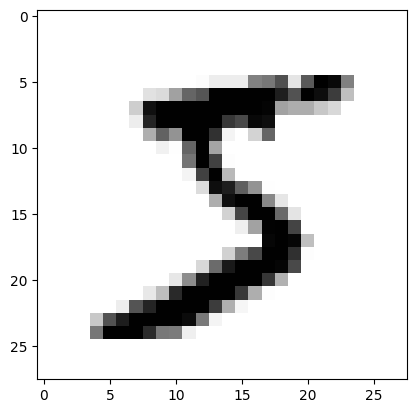

5


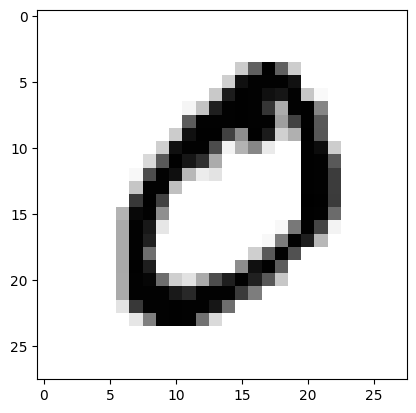

0


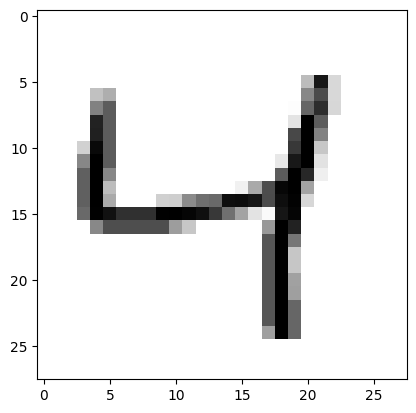

4


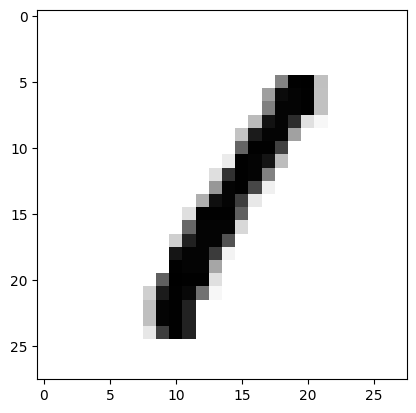

1


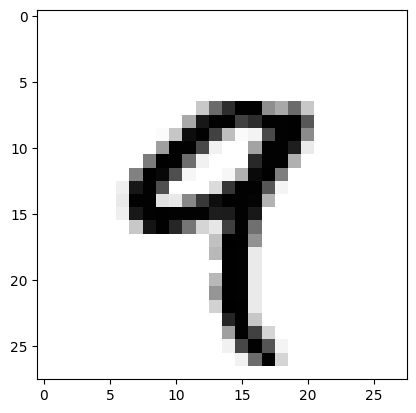

9


In [12]:
import matplotlib.pyplot as plt
for i in range(0,5):
    image = train_inp[i].reshape(28,28)
    fig = plt.figure
    plt.imshow(image, cmap='gray_r')
    plt.show()
    print(np.argmax(train_out[i]))